In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from keras.layers import  Dense, Activation, Input
from keras.models import Model, load_model
from keras.optimizers import Adam
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import random 
import gym

Using TensorFlow backend.


In [2]:
!pip install gym
!pip install gym[all]

  Using cached https://files.pythonhosted.org/packages/cf/8c/64e0630b3d450244feef0688d90eab2448631e40ba6bdbd90a70b84898e7/mujoco-py-1.50.1.68.tar.gz
  Using cached https://files.pythonhosted.org/packages/06/bd/6cdc3fd994b0649dcf5d9bad85bd9e26172308bbe9a421bfc6fdbf5081a6/box2d_py-2.3.8-cp36-cp36m-manylinux1_x86_64.whl
  ERROR: Failed building wheel for mujoco-py
  Running setup.py clean for mujoco-py
Failed to build mujoco-py
    Running setup.py install for mujoco-py ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-rm7hi0y3/mujoco-py/setup.py'"'"'; __file__='"'"'/tmp/pip-install-rm7hi0y3/mujoco-py/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-034oi1l3/install-record.txt --single-version-externally-managed --compile Check the l

2)a) Random agent


In [3]:
env = gym.make('MountainCar-v0')
print('action space')
print(env.action_space)
print('observation space')
print(env.observation_space)


action space
Discrete(3)
observation space
Box(2,)


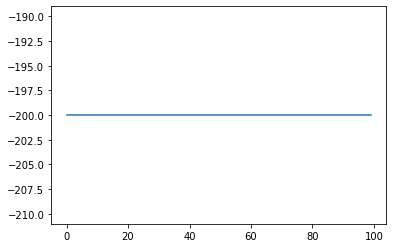

In [4]:
rand_scores = []
for i_episode in range(100):
    observation = env.reset()
    score = 0
    while True:
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        score += reward
        if done:
            break
    rand_scores.append(score)
env.close()
x_axis = [i for i in range(100)]
plt.plot(x_axis, rand_scores)
plt.show()

2)b)


In [0]:
class ReplayBuffer():
    def __init__(self, max_size):
      self.max_size = max_size
      self.mem = deque()
      self.size = 0

    def store_transition(self, observation, action, reward, observation_, done):
      if self.size < self.max_size:
        self.mem.append((observation, action, reward, observation_, done))
        self.size += 1
      else:
        self.mem.popleft()
        self.mem.append((observation, action, reward, observation_, done))

    def sample_buffer(self):
      batch = random.sample(self.mem, batch_size)
      return batch

In [0]:
def get_model():
  main_input = Input(shape=(input_dim,), name='main_input')
  dense_1 = Dense(layer1_size, activation='relu')(main_input)
  dense_2 = Dense(layer2_size, activation='relu')(dense_1)
  main_output = Dense(n_actions, activation=None, name='main_output')(dense_2)

  model = Model(input=[main_input], output=[main_output])
  model.compile(optimizer=Adam(lr=lr), loss='mean_squared_error')
  
  return model

In [0]:
def store_transition(state, action, reward, new_state, done):
    memory.store_transition(state, action, reward, new_state, done)

def choose_action(observation):
    if np.random.random() < epsilon:
        action = np.random.choice(action_space)
    else:
        state = np.array([observation])
        actions = q_eval.predict(state)
        action = np.argmax(actions, axis=1)[0]
        # action = K.get_value(tf.math.argmax(actions, axis=1)[0])
        # action = tf.math.argmax(actions, axis=1).numpy()[0]

    return action

def learn(ddqn = False):
    global q_next,epsilon,learn_step_counter

    if memory.size < batch_size:
        return

    if learn_step_counter % replace == 0:
        q_next.set_weights(q_eval.get_weights())

    sample_transitions = memory.sample_buffer()
    observations, actions, rewards, observations_, dones = zip(*sample_transitions)
    
    observations = np.array(observations)
    observations_ = np.array(observations_)  

    q_target = q_eval.predict(observations)
    q_pred = q_eval.predict(observations_)
    if ddqn:
      q_pred_next = q_next.predict(observations_)
    new_actions = np.argmax(q_pred, axis=1)
    for idx, terminal in enumerate(dones):
      if terminal:
        q_target[idx, actions[idx]] = rewards[idx]
      else:
        if ddqn:
          q_target[idx, actions[idx]] = rewards[idx] + gamma*q_pred_next[idx, new_actions[idx]]
        else:
          q_target[idx, actions[idx]] = rewards[idx] + gamma*q_pred[idx, new_actions[idx]]

    q_eval.train_on_batch(observations, q_target)

    epsilon = epsilon - eps_dec if epsilon > \
                    eps_min else eps_min

    learn_step_counter += 1

In [0]:
n_epsiodes = 100000
layer1_size = 16
layer2_size = 16
input_dim = 2
gamma=0.99
mem_size=100000
batch_size=64
eps_min=0.01
n_actions=3
action_space = [i for i in range(n_actions)]
eps_dec=1e-3
replace=100

In [0]:
def agent(ddqn=False):
  env = gym.make('MountainCar-v0')
  n_games = 2000

  scores, avg_scores, eps_history = [], [], []

  for i in range(n_games):
      done = False
      score = 0
      observation = env.reset()
      while not done:
          action = choose_action(observation)
          observation_, reward, done, info = env.step(action)
          score += reward
          memory.store_transition(observation, action, reward, observation_, done)
          observation = observation_
          learn(ddqn)
      eps_history.append(epsilon)
      scores.append(score)
      avg_score = np.mean(scores[-100:])
      avg_scores.append(avg_score)
      print('episode ', i, 'score %.1f' % score,
              'average score %.1f' % avg_score,
              'epsilon %.2f' % epsilon)

      if avg_score >= -125:
        break

  x_axis = [j for j in range(i+1)]
  plt.plot(x_axis, avg_scores)
  plt.show()

2)c) Different learning rates

Learning rate: 0.001

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  import sys


episode  0 score -200.0 average score -200.0 epsilon 0.86
episode  1 score -200.0 average score -200.0 epsilon 0.66
episode  2 score -200.0 average score -200.0 epsilon 0.46
episode  3 score -200.0 average score -200.0 epsilon 0.26
episode  4 score -200.0 average score -200.0 epsilon 0.06
episode  5 score -200.0 average score -200.0 epsilon 0.01
episode  6 score -200.0 average score -200.0 epsilon 0.01
episode  7 score -200.0 average score -200.0 epsilon 0.01
episode  8 score -200.0 average score -200.0 epsilon 0.01
episode  9 score -200.0 average score -200.0 epsilon 0.01
episode  10 score -200.0 average score -200.0 epsilon 0.01
episode  11 score -200.0 average score -200.0 epsilon 0.01
episode  12 score -200.0 average score -200.0 epsilon 0.01
episode  13 score -200.0 average score -200.0 epsilon 0.01
episode  14 score -200.0 average score -200.0 epsilon 0.01
episode  15 score -200.0 average score -200.0 epsilon 0.01
episode  16 score -200.0 average score -200.0 epsilon 0.01
episode

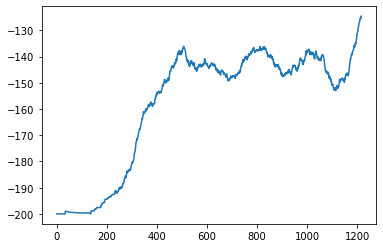

In [10]:
np.random.seed(0)

learn_step_counter = 0
epsilon=1
lr=1e-3
memory = ReplayBuffer(mem_size)
q_eval = get_model()
q_next = get_model()

agent()

Learning rate: 0.01

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  import sys


episode  0 score -200.0 average score -200.0 epsilon 0.86
episode  1 score -200.0 average score -200.0 epsilon 0.66
episode  2 score -200.0 average score -200.0 epsilon 0.46
episode  3 score -200.0 average score -200.0 epsilon 0.26
episode  4 score -200.0 average score -200.0 epsilon 0.06
episode  5 score -200.0 average score -200.0 epsilon 0.01
episode  6 score -200.0 average score -200.0 epsilon 0.01
episode  7 score -200.0 average score -200.0 epsilon 0.01
episode  8 score -200.0 average score -200.0 epsilon 0.01
episode  9 score -200.0 average score -200.0 epsilon 0.01
episode  10 score -200.0 average score -200.0 epsilon 0.01
episode  11 score -200.0 average score -200.0 epsilon 0.01
episode  12 score -200.0 average score -200.0 epsilon 0.01
episode  13 score -200.0 average score -200.0 epsilon 0.01
episode  14 score -200.0 average score -200.0 epsilon 0.01
episode  15 score -200.0 average score -200.0 epsilon 0.01
episode  16 score -200.0 average score -200.0 epsilon 0.01
episode

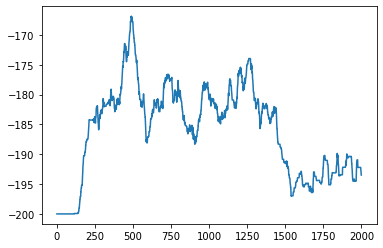

In [11]:
learn_step_counter = 0
epsilon=1
lr=1e-2
memory = ReplayBuffer(mem_size)
q_eval = get_model()
q_next = get_model()

agent()

Learning rate: 0.1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  import sys


episode  0 score -200.0 average score -200.0 epsilon 0.86
episode  1 score -200.0 average score -200.0 epsilon 0.66
episode  2 score -200.0 average score -200.0 epsilon 0.46
episode  3 score -200.0 average score -200.0 epsilon 0.26
episode  4 score -200.0 average score -200.0 epsilon 0.06
episode  5 score -200.0 average score -200.0 epsilon 0.01
episode  6 score -200.0 average score -200.0 epsilon 0.01
episode  7 score -200.0 average score -200.0 epsilon 0.01
episode  8 score -200.0 average score -200.0 epsilon 0.01
episode  9 score -200.0 average score -200.0 epsilon 0.01
episode  10 score -200.0 average score -200.0 epsilon 0.01
episode  11 score -200.0 average score -200.0 epsilon 0.01
episode  12 score -200.0 average score -200.0 epsilon 0.01
episode  13 score -200.0 average score -200.0 epsilon 0.01
episode  14 score -200.0 average score -200.0 epsilon 0.01
episode  15 score -200.0 average score -200.0 epsilon 0.01
episode  16 score -200.0 average score -200.0 epsilon 0.01
episode

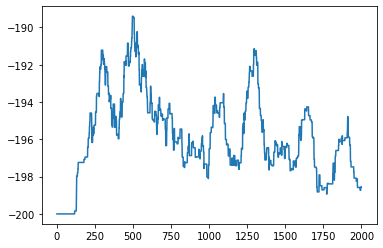

In [12]:
learn_step_counter = 0
epsilon=1
lr=1e-1
memory = ReplayBuffer(mem_size)
q_eval = get_model()
q_next = get_model()

agent()

Learning rate: 0.5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  import sys


episode  0 score -200.0 average score -200.0 epsilon 0.86
episode  1 score -200.0 average score -200.0 epsilon 0.66
episode  2 score -200.0 average score -200.0 epsilon 0.46
episode  3 score -200.0 average score -200.0 epsilon 0.26
episode  4 score -200.0 average score -200.0 epsilon 0.06
episode  5 score -200.0 average score -200.0 epsilon 0.01
episode  6 score -200.0 average score -200.0 epsilon 0.01
episode  7 score -200.0 average score -200.0 epsilon 0.01
episode  8 score -200.0 average score -200.0 epsilon 0.01
episode  9 score -200.0 average score -200.0 epsilon 0.01
episode  10 score -200.0 average score -200.0 epsilon 0.01
episode  11 score -200.0 average score -200.0 epsilon 0.01
episode  12 score -200.0 average score -200.0 epsilon 0.01
episode  13 score -200.0 average score -200.0 epsilon 0.01
episode  14 score -200.0 average score -200.0 epsilon 0.01
episode  15 score -200.0 average score -200.0 epsilon 0.01
episode  16 score -200.0 average score -200.0 epsilon 0.01
episode

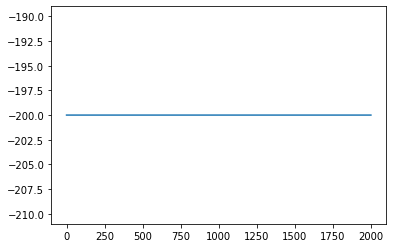

In [13]:
learn_step_counter = 0
epsilon=1
lr=5e-1
memory = ReplayBuffer(mem_size)
q_eval = get_model()
q_next = get_model()

agent()

2)d) DDQN

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  import sys


episode  0 score -200.0 average score -200.0 epsilon 0.86
episode  1 score -200.0 average score -200.0 epsilon 0.66
episode  2 score -200.0 average score -200.0 epsilon 0.46
episode  3 score -200.0 average score -200.0 epsilon 0.26
episode  4 score -200.0 average score -200.0 epsilon 0.06
episode  5 score -200.0 average score -200.0 epsilon 0.01
episode  6 score -200.0 average score -200.0 epsilon 0.01
episode  7 score -200.0 average score -200.0 epsilon 0.01
episode  8 score -200.0 average score -200.0 epsilon 0.01
episode  9 score -200.0 average score -200.0 epsilon 0.01
episode  10 score -200.0 average score -200.0 epsilon 0.01
episode  11 score -200.0 average score -200.0 epsilon 0.01
episode  12 score -200.0 average score -200.0 epsilon 0.01
episode  13 score -200.0 average score -200.0 epsilon 0.01
episode  14 score -200.0 average score -200.0 epsilon 0.01
episode  15 score -200.0 average score -200.0 epsilon 0.01
episode  16 score -200.0 average score -200.0 epsilon 0.01
episode

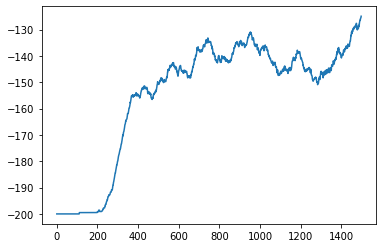

In [14]:
np.random.seed(1)

learn_step_counter = 0
epsilon=1
lr=1e-3
memory = ReplayBuffer(mem_size)
q_eval = get_model()
q_next = get_model()

agent()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  import sys


episode  0 score -200.0 average score -200.0 epsilon 0.86
episode  1 score -200.0 average score -200.0 epsilon 0.66
episode  2 score -200.0 average score -200.0 epsilon 0.46
episode  3 score -200.0 average score -200.0 epsilon 0.26
episode  4 score -200.0 average score -200.0 epsilon 0.06
episode  5 score -200.0 average score -200.0 epsilon 0.01
episode  6 score -200.0 average score -200.0 epsilon 0.01
episode  7 score -200.0 average score -200.0 epsilon 0.01
episode  8 score -200.0 average score -200.0 epsilon 0.01
episode  9 score -200.0 average score -200.0 epsilon 0.01
episode  10 score -200.0 average score -200.0 epsilon 0.01
episode  11 score -200.0 average score -200.0 epsilon 0.01
episode  12 score -200.0 average score -200.0 epsilon 0.01
episode  13 score -200.0 average score -200.0 epsilon 0.01
episode  14 score -200.0 average score -200.0 epsilon 0.01
episode  15 score -200.0 average score -200.0 epsilon 0.01
episode  16 score -200.0 average score -200.0 epsilon 0.01
episode

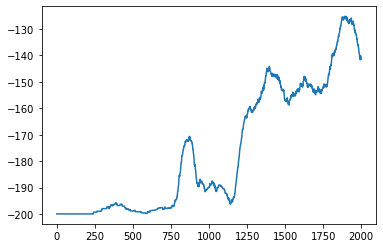

In [15]:
np.random.seed(2)

learn_step_counter = 0
epsilon=1
lr=1e-3
memory = ReplayBuffer(mem_size)
q_eval = get_model()
q_next = get_model()

agent()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  import sys


episode  0 score -200.0 average score -200.0 epsilon 0.86
episode  1 score -200.0 average score -200.0 epsilon 0.66
episode  2 score -200.0 average score -200.0 epsilon 0.46
episode  3 score -200.0 average score -200.0 epsilon 0.26
episode  4 score -200.0 average score -200.0 epsilon 0.06
episode  5 score -200.0 average score -200.0 epsilon 0.01
episode  6 score -200.0 average score -200.0 epsilon 0.01
episode  7 score -200.0 average score -200.0 epsilon 0.01
episode  8 score -200.0 average score -200.0 epsilon 0.01
episode  9 score -200.0 average score -200.0 epsilon 0.01
episode  10 score -200.0 average score -200.0 epsilon 0.01
episode  11 score -200.0 average score -200.0 epsilon 0.01
episode  12 score -200.0 average score -200.0 epsilon 0.01
episode  13 score -200.0 average score -200.0 epsilon 0.01
episode  14 score -200.0 average score -200.0 epsilon 0.01
episode  15 score -200.0 average score -200.0 epsilon 0.01
episode  16 score -200.0 average score -200.0 epsilon 0.01
episode

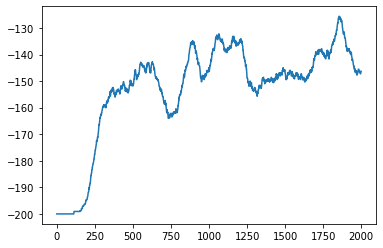

In [16]:
np.random.seed(0)

learn_step_counter = 0
epsilon=1
lr=1e-3
memory = ReplayBuffer(mem_size)
q_eval = get_model()
q_next = get_model()

agent(True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  import sys


episode  0 score -200.0 average score -200.0 epsilon 0.86
episode  1 score -200.0 average score -200.0 epsilon 0.66
episode  2 score -200.0 average score -200.0 epsilon 0.46
episode  3 score -200.0 average score -200.0 epsilon 0.26
episode  4 score -200.0 average score -200.0 epsilon 0.06
episode  5 score -200.0 average score -200.0 epsilon 0.01
episode  6 score -200.0 average score -200.0 epsilon 0.01
episode  7 score -200.0 average score -200.0 epsilon 0.01
episode  8 score -200.0 average score -200.0 epsilon 0.01
episode  9 score -200.0 average score -200.0 epsilon 0.01
episode  10 score -200.0 average score -200.0 epsilon 0.01
episode  11 score -200.0 average score -200.0 epsilon 0.01
episode  12 score -200.0 average score -200.0 epsilon 0.01
episode  13 score -200.0 average score -200.0 epsilon 0.01
episode  14 score -200.0 average score -200.0 epsilon 0.01
episode  15 score -200.0 average score -200.0 epsilon 0.01
episode  16 score -200.0 average score -200.0 epsilon 0.01
episode

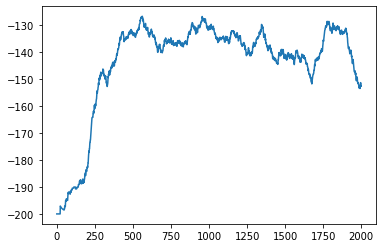

In [17]:
np.random.seed(1)

learn_step_counter = 0
epsilon=1
lr=1e-3
memory = ReplayBuffer(mem_size)
q_eval = get_model()
q_next = get_model()

agent(True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  import sys


episode  0 score -200.0 average score -200.0 epsilon 0.86
episode  1 score -200.0 average score -200.0 epsilon 0.66
episode  2 score -200.0 average score -200.0 epsilon 0.46
episode  3 score -200.0 average score -200.0 epsilon 0.26
episode  4 score -200.0 average score -200.0 epsilon 0.06
episode  5 score -200.0 average score -200.0 epsilon 0.01
episode  6 score -200.0 average score -200.0 epsilon 0.01
episode  7 score -200.0 average score -200.0 epsilon 0.01
episode  8 score -200.0 average score -200.0 epsilon 0.01
episode  9 score -200.0 average score -200.0 epsilon 0.01
episode  10 score -200.0 average score -200.0 epsilon 0.01
episode  11 score -200.0 average score -200.0 epsilon 0.01
episode  12 score -200.0 average score -200.0 epsilon 0.01
episode  13 score -200.0 average score -200.0 epsilon 0.01
episode  14 score -200.0 average score -200.0 epsilon 0.01
episode  15 score -200.0 average score -200.0 epsilon 0.01
episode  16 score -200.0 average score -200.0 epsilon 0.01
episode

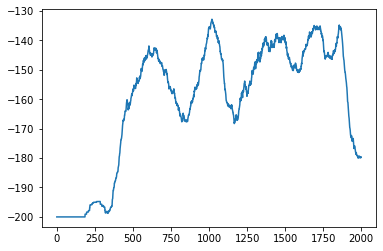

In [18]:
np.random.seed(2)

learn_step_counter = 0
epsilon=1
lr=1e-3
memory = ReplayBuffer(mem_size)
q_eval = get_model()
q_next = get_model()

agent(True)